# ORGANISATION NATIONAL DE LUTTE CONTRE LE FAUX MONNAYAGE - Pré-traitement des données

# Introduction

In [1]:
## Importation des modules & librairies

# Manipulation de données
import pandas as pd  # Manipulations générales
import numpy as np  # Calculs numériques

# Normalisation de données
from sklearn.preprocessing import StandardScaler # Scaling

# Visualisation de données
import matplotlib.pyplot as plt  # Graphiques
import seaborn as sns # Graphiques

# Régression linéaire
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Distribution
from scipy.stats import t # Résidus Studentisés
from statsmodels.stats.outliers_influence import OLSInfluence # Distance de Cook

# Tests statistiques
from statsmodels.stats.outliers_influence import variance_inflation_factor # Colinéarité
import statsmodels # Homoscédasticité
from scipy.stats import shapiro # Normalité

# Division des données pour l'entraînement et le test
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Validation croisée
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Régression Logistique
from sklearn.linear_model import LogisticRegression

# KMeans
from sklearn.cluster import KMeans

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Matrice de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Enregistrement des modèles
import joblib

In [2]:
## Mise en place des fonctions
def explore_dataframe(data_to_analyse):
    """
    Effectue une analyse exploratoire basique sur un dataframe donné.

    Parameters:
    data_to_analyse (DataFrame): Le dataframe à analyser.
    """
    # Dimensions du dataframe
    print('*' * 40 + " DIMENSIONS " + '*' * 44)
    print(f"Le dataframe comporte {data_to_analyse.shape[1]} variable(s) pour {data_to_analyse.shape[0]} observation(s).")

    # Typologies des variables
    print('*' * 40 + " TYPOLOGIES " + '*' * 44)
    for col, dtype in data_to_analyse.dtypes.items():
        print(f"{col} : {dtype}")

    # Effectifs des variables
    print('*' * 40 + " EFFECTIFS " + '*' * 45)
    for col, count in data_to_analyse.describe(include='all').loc['count'].items():
        print(f"{col} : {count}")

    # Valeurs nulles dans le dataframe
    print('*' * 40 + " VALEURS NULLES " + '*' * 40)
    for col, count in data_to_analyse.isnull().sum().items():
        print(f"{col} : {count}")

    # Duplicats dans le dataframe
    print('*' * 40 + " DUPLICATS " + '*' * 45)
    for col, count in data_to_analyse[data_to_analyse.duplicated()].count().items():
        print(f"{col} : {count}")

## Mise en place d'une fonction pour afficher les statistiques descriptives d'un dataframe
def calcul_statistiques_descriptives(data):
    # Calcul du nombre d'observations
    nbr_observations = data.shape[0]

    # Calcul du nombre de variables
    nbr_variables = data.shape[1]

    # Calcul de la moyenne
    moyenne = data.mean()

    # Calcul de la médiane
    mediane = data.median()

    # Calcul de l'écart-type
    std = data.std()

    # Valeur minimale
    min_val = data.min()

    # Valeur maximale
    max_val = data.max()

    # Récupération de la typologie
    data_type = data.dtypes

    # Calcul du nombre de valeurs manquantes
    nbr_valeurs_manquantes = data.isnull().sum()

    # Création d'un DataFrame pour les statistiques descriptives
    statistiques_descriptives = pd.DataFrame({
        'Nbr_individus': nbr_observations,
        'Nbr_variables': nbr_variables,
        'Type': data_type,
        'Moyenne': moyenne,
        'Mediane': mediane,
        'Ecart_type': std,
        'Valeur_min': min_val,
        'Valeur_max': max_val,
        'Nbr_Null': nbr_valeurs_manquantes,
        '%_Null': round((nbr_valeurs_manquantes / nbr_observations) * 100, 2)
    })

    return statistiques_descriptives

## Création d'une fonction de régression logistique Backward
def regression_logistic_backward(data, response):

    # Récupération des colonnes numériques du DataFrame
    variables_numériques_2 = set(data._get_numeric_data().columns)

    # Gestion des réponses
    if response in variables_numériques_2:
        variables_numériques_2.remove(response)
    condition_2 = True

    # Boucle de sélection
    while variables_numériques_2 and condition_2:

        # Formule de modèle
        formula = "{} ~ {} + 1".format(response, ' + '.join(variables_numériques_2))
        print('_______________________________')
        print(formula)

        # Entraînement du modèle
        model = smf.logit(formula, data).fit()

        # Récupération des p-values des paramètres
        score = model.pvalues[1:]

        # Sélection du paramètre avec la p-value la plus élevée
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value:', round(toRemove.values[0], 3), ')')
            variables_numériques_2.remove(toRemove.index[0])
        else:
            condition_2 = False
            print('is the final model!')
        print('')

    # Affichage des résultat
    print(model.summary())
    return model

In [3]:
## Importation des données initiales
data = pd.read_csv("billets.csv",sep=";")

# Pré-traitement des données & analyse exploratoire

In [4]:
# Vérification du nombre de billet conforme et non conforme
print("Le nombre de billets conforme est de :",data.loc[data["is_genuine"]==True]["is_genuine"].count())
print("Le nombre de billets non conforme est de :",data.loc[data["is_genuine"]==False]["is_genuine"].count())

# Conversion de la variable 'conforme/non-conforme' en type booléen
# data["is_genuine"].unique()
data["is_genuine"].replace([True, False], [1,0], inplace=True)

Le nombre de billets conforme est de : 1000
Le nombre de billets non conforme est de : 500


In [5]:
## Analyse exploratoire
explore_dataframe(data)

**************************************** DIMENSIONS ********************************************
Le dataframe comporte 7 variable(s) pour 1500 observation(s).
**************************************** TYPOLOGIES ********************************************
is_genuine : int64
diagonal : float64
height_left : float64
height_right : float64
margin_low : float64
margin_up : float64
length : float64
**************************************** EFFECTIFS *********************************************
is_genuine : 1500.0
diagonal : 1500.0
height_left : 1500.0
height_right : 1500.0
margin_low : 1463.0
margin_up : 1500.0
length : 1500.0
**************************************** VALEURS NULLES ****************************************
is_genuine : 0
diagonal : 0
height_left : 0
height_right : 0
margin_low : 37
margin_up : 0
length : 0
**************************************** DUPLICATS *********************************************
is_genuine : 0
diagonal : 0
height_left : 0
height_right : 0
margin_low : 

Le fichier comporte les dimensions caractéristiques de 1500 billets ( 1000 billets authentiques et 500 faux billets ).

Il nous indique :
- La marge haute et basse
- Le hauteur à droite et à gauche
- La longueur du billet et de sa diagonale
- Si le billet est authentique ou non

In [6]:
# Statistiques descriptives générales
calcul_statistiques_descriptives(data)

,Nbr_individus,Nbr_variables,Type,Moyenne,Mediane,Ecart_type,Valeur_min,Valeur_max,Nbr_Null,%_Null
is_genuine,1500,7,int64,0.666667,1.00,0.471562,0.00,1.00,0,0.00
diagonal,1500,7,float64,171.958440,171.96,0.305195,171.04,173.01,0,0.00
height_left,1500,7,float64,104.029533,104.04,0.299462,103.14,104.88,0,0.00
height_right,1500,7,float64,103.920307,103.92,0.325627,102.82,104.95,0,0.00
margin_low,1500,7,float64,4.485967,4.31,0.663813,2.98,6.90,37,2.47
margin_up,1500,7,float64,3.151473,3.14,0.231813,2.27,3.91,0,0.00
length,1500,7,float64,112.678500,112.96,0.872730,109.49,114.44,0,0.00


37 valeurs sont manquantes au sein de la variable 'margin_low', ce qui représente 2,47% de notre échantillon.

In [7]:
# Statistiques descriptives des billets conformes
calcul_statistiques_descriptives(data.loc[data["is_genuine"]==True])

,Nbr_individus,Nbr_variables,Type,Moyenne,Mediane,Ecart_type,Valeur_min,Valeur_max,Nbr_Null,%_Null
is_genuine,1000,7,int64,1.000000,1.000,0.000000,1.00,1.00,0,0.0
diagonal,1000,7,float64,171.987080,171.990,0.300441,171.04,172.92,0,0.0
height_left,1000,7,float64,103.949130,103.950,0.300231,103.14,104.86,0,0.0
height_right,1000,7,float64,103.808650,103.810,0.291570,102.82,104.95,0,0.0
margin_low,1000,7,float64,4.116097,4.110,0.319124,2.98,5.04,29,2.9
margin_up,1000,7,float64,3.052130,3.050,0.186340,2.27,3.74,0,0.0
length,1000,7,float64,113.202430,113.205,0.359552,111.76,114.44,0,0.0


29 valeurs sont manquantes pour les billets authentiques ( 2,9% ).

In [8]:
# Statistiques descriptives des billets non conformes
calcul_statistiques_descriptives(data.loc[data["is_genuine"]==False])

,Nbr_individus,Nbr_variables,Type,Moyenne,Mediane,Ecart_type,Valeur_min,Valeur_max,Nbr_Null,%_Null
is_genuine,500,7,int64,0.000000,0.00,0.000000,0.00,0.00,0,0.0
diagonal,500,7,float64,171.901160,171.91,0.306861,171.04,173.01,0,0.0
height_left,500,7,float64,104.190340,104.18,0.223758,103.51,104.88,0,0.0
height_right,500,7,float64,104.143620,104.16,0.270878,103.43,104.95,0,0.0
margin_low,500,7,float64,5.215935,5.19,0.553531,3.82,6.90,8,1.6
margin_up,500,7,float64,3.350160,3.35,0.180498,2.92,3.91,0,0.0
length,500,7,float64,111.630640,111.63,0.615543,109.49,113.85,0,0.0


8 valeurs sont manquantes pour les billets authentiques ( 1,6% ).

In [9]:
# Analyse des écarts de médianes en pourcentage
def calculate_difference(data, column_name):
    median_True = data.loc[data["is_genuine"] == True][column_name].median()
    median_False = data.loc[data["is_genuine"] == False][column_name].median()
    difference = ((median_True - median_False) / median_True) * 100
    return round(difference, 2)

# Liste des colonnes à traiter
columns = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]

# Calcul des différences pour chaque variable
differences = {}
for column in columns:
    differences[column] = calculate_difference(data, column)

# Affichage des résultats sous forme de dataframe
ecart_pourcentage = pd.DataFrame(data=[differences], index=["Ecart median (%)"])
ecart_pourcentage

,diagonal,height_left,height_right,margin_low,margin_up,length
Ecart median (%),0.05,-0.22,-0.34,-26.28,-9.84,1.39


En comparant les médianes des billets authentiques à ceux non-conforme, on constate notamment :
- Une réduction de 26,28% de la marge basse des billets authentiques par rapport aux billets non authentiques.
- La marge haute des billets authentiques est inférieure de 9,84% par rapport aux billets non authentiques.
- Il y a une augmentation de 1,39% dans la longueur des billets authentiques par rapport aux billets non authentiques.

In [10]:
# Analyse descriptive
data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_genuine,1500.0,0.666667,0.471562,0.00,0.000,1.00,1.00,1.00
diagonal,1500.0,171.958440,0.305195,171.04,171.750,171.96,172.17,173.01
height_left,1500.0,104.029533,0.299462,103.14,103.820,104.04,104.23,104.88
height_right,1500.0,103.920307,0.325627,102.82,103.710,103.92,104.15,104.95
margin_low,1463.0,4.485967,0.663813,2.98,4.015,4.31,4.87,6.90
margin_up,1500.0,3.151473,0.231813,2.27,2.990,3.14,3.31,3.91
length,1500.0,112.678500,0.872730,109.49,112.030,112.96,113.34,114.44


In [11]:
## Normalisation des données

# Création d'une instance de StandardScaler
scaler = StandardScaler()

# Mise à l'écart de la variable 'is_genuine' pour la normalisation ( variable qualitative )
data_to_scale = data.drop('is_genuine', axis=1)
is_genuine = data['is_genuine']

# Scaling
scaled_process = scaler.fit_transform(data_to_scale)

# Mise en place d'un dataframe
scaled_data = pd.DataFrame(scaled_process, columns=data_to_scale.columns, index=data_to_scale.index)

# Ajout de la variable 'is_genuine'
scaled_data.insert(0, 'is_genuine', is_genuine)

# Vérification que les valeurs de 'is_genuine' correspondent bien avant et après la normalisation
assert (scaled_data['is_genuine'] == data['is_genuine']).all(), "Les valeurs de 'is_genuine' ne correspondent pas après normalisation"

# Aperçu
scaled_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651
1,1,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666
2,1,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901
3,1,-1.961498,-0.399294,0.060498,-1.304982,-0.610494,0.953075
4,1,-0.748754,0.836669,-1.414072,-0.672057,1.417677,-0.158750


In [12]:
# Calcul des moyennes et des écarts types avant et après normalisation
mean_std_before = data_to_scale.agg(['mean', 'std']).T
mean_std_after = scaled_data.drop('is_genuine', axis=1).agg(['mean', 'std']).T

# Renommer les colonnes pour une meilleure compréhension
mean_std_before.columns = ['Original_Mean', 'Original_Std']
mean_std_after.columns = ['Scaled_Mean', 'Scaled_Std']

# Fusion des deux DataFrames pour affichage
table_final = mean_std_before.join(mean_std_after)

# Affichage des résultats
table_final.round(2).T

,diagonal,height_left,height_right,margin_low,margin_up,length
Original_Mean,171.96,104.03,103.92,4.49,3.15,112.68
Original_Std,0.31,0.30,0.33,0.66,0.23,0.87
Scaled_Mean,-0.00,0.00,-0.00,0.00,-0.00,0.00
Scaled_Std,1.00,1.00,1.00,1.00,1.00,1.00


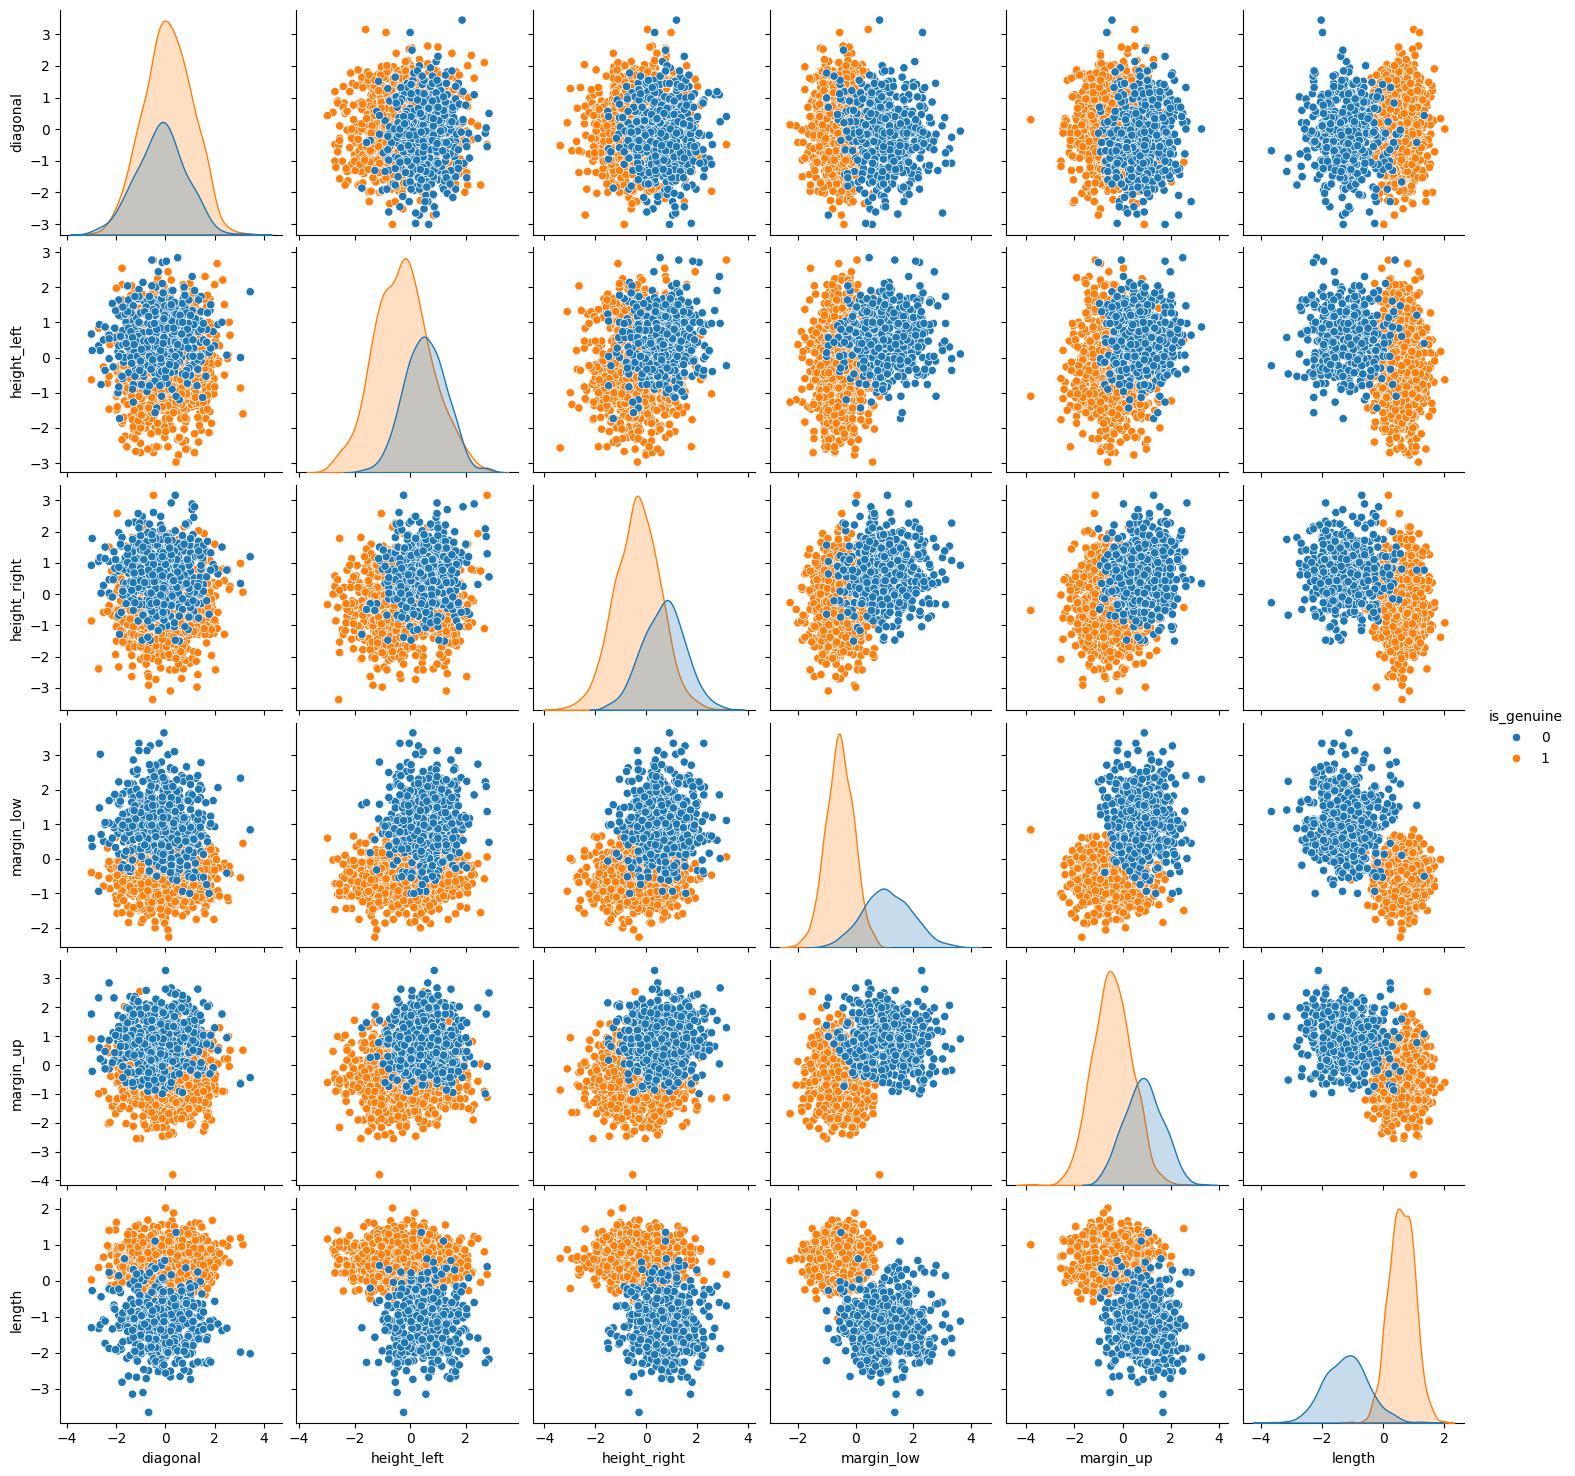

In [13]:
# Pairplot
pairplot = sns.pairplot(scaled_data, hue="is_genuine")

# Enregistrer le graphique
plt.savefig("pairplot.png")

# Afficher le graphique
plt.show()

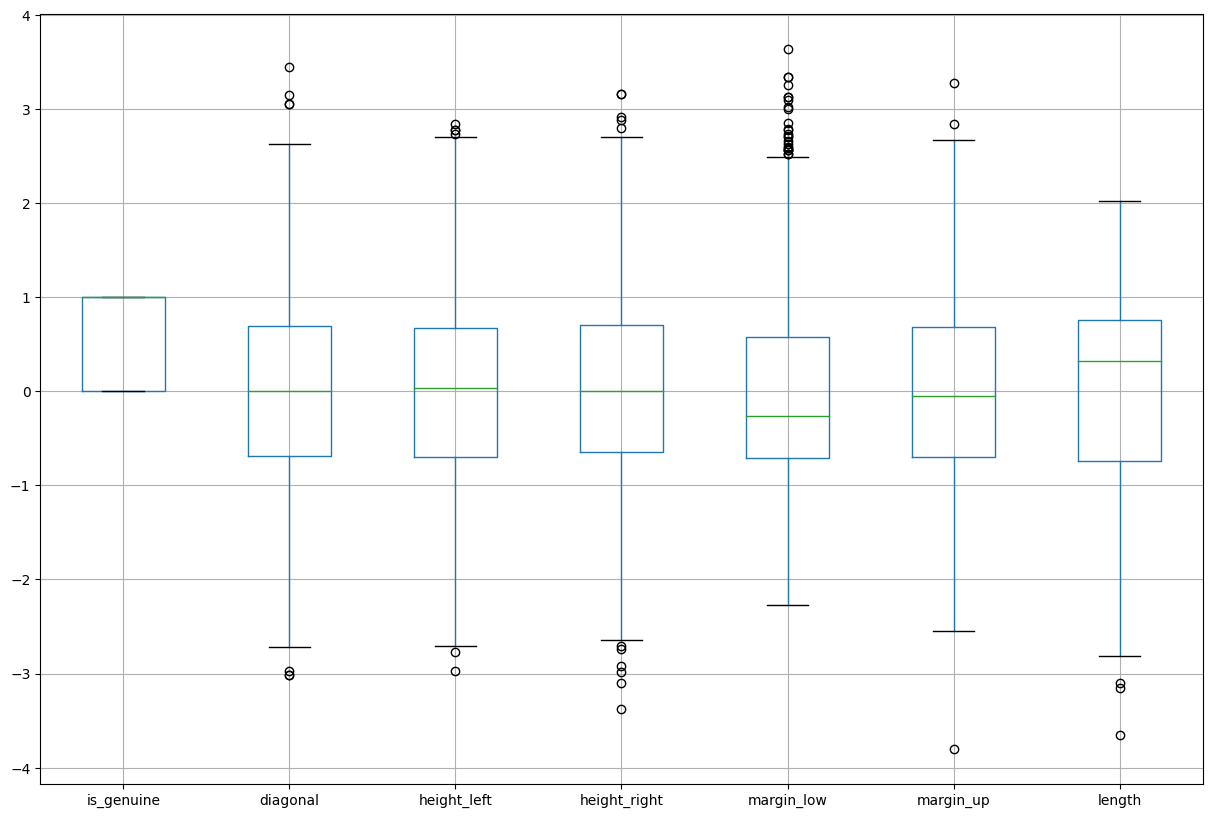

In [14]:
# Boxplot
fig, ax = plt.subplots(figsize=(15,10))
scaled_data.boxplot(ax=ax)

# Enregistrer le graphique
plt.savefig("boxplot.png")

# Afficher le graphique
plt.show()

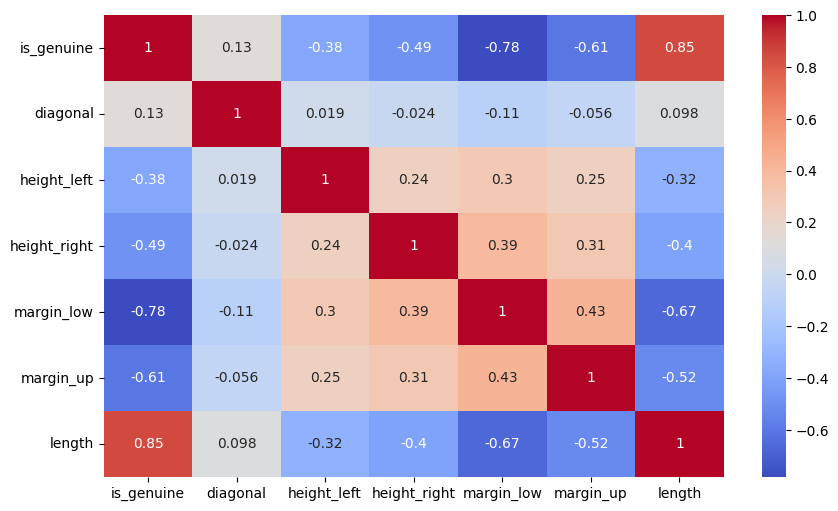

In [15]:
# Heatmap ( Corrélation de Pearson )
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(scaled_data.corr(), annot=True, cmap="coolwarm")

# Enregistrer le graphique
plt.savefig("heatmap.png")

# Afficher le graphique
plt.show()

## Gestion des valeurs manquantes



Plusieurs possibilités s'offrent à nous, notamment :

- Supprimer ces individus ( 2,47% des valeurs totales )
- Remplacer les valeurs manquantes par la moyenne de notre échantillon
- Remplacer les valeurs manquantes par la médiane de notre échantillon
- Utiliser un modèle de régression linéaire, pour tenter de reconstituer les données.

Ici, pour les besoins du cas pratique, nous opterons pour la dernière méthode : la régression linéaire.

On souhaite "déduire" les 37 valeurs manquantes de la variable dépendante "margin_low", en utilisant les autres caractéristiques disponibles.

In [16]:
# Création d'un dataframe comportant uniquement les valeurs nulles
valeurs_manquantes = scaled_data.loc[scaled_data["margin_low"].isna()]

# Vérification des dimensions
print(f"Le dataframe comporte {valeurs_manquantes.shape[1]} variable(s) pour {valeurs_manquantes.shape[0]} observation(s).")

# Aperçu du dataframe
valeurs_manquantes.head()

Le dataframe comporte 7 variable(s) pour 37 observation(s).


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,-0.060441,-0.466103,-1.444792,NaN,0.425168,0.127803
99,1,-0.093217,0.135176,0.797784,NaN,-0.049510,0.460204
151,1,0.365659,-0.766742,1.412188,NaN,-0.567341,0.288272
197,1,-1.666506,-1.234404,-0.369585,NaN,2.021814,0.677984
241,1,-0.420986,0.369007,0.429141,NaN,-0.567341,-0.365069


In [17]:
# Création d'un dataframe sans valeurs manquantes
clean_data = scaled_data.dropna()

# Vérification des dimensions
print(f"Le dataframe comporte {clean_data.shape[1]} variable(s) pour {clean_data.shape[0]} observation(s).")

# Aperçu du dataframe
clean_data.head()

Le dataframe comporte 7 variable(s) pour 1463 observation(s).


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651
1,1,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666
2,1,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901
3,1,-1.961498,-0.399294,0.060498,-1.304982,-0.610494,0.953075
4,1,-0.748754,0.836669,-1.414072,-0.672057,1.417677,-0.158750


Régression linéaire sans l'information d'authenticité des billets.

In [18]:
# Définition de la formule pour la régression linéaire multiple
formula = 'margin_low ~ diagonal + height_left + height_right + margin_up + length'

# Entraînement du modèle
regression_without = smf.ols(formula, data=clean_data).fit()

# Aperçu du résultat
print(regression_without.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          2.60e-202
Time:                        08:41:05   Log-Likelihood:                -1601.3
No. Observations:                1463   AIC:                             3215.
Df Residuals:                    1457   BIC:                             3246.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0038      0.019     -0.198   

Toutes les variables sont statistiquement significatives (P-value < 0.05).

On peut néanmoins simplifier le modèle en retirant la variable 'diagonal'
(P-value = 0.007).

In [19]:
# Définir la formule pour la régression linéaire multiple
formula = 'margin_low ~ height_left + height_right + margin_up + length'

# Entraînement du modèle
regression_without = smf.ols(formula, data=clean_data).fit()

# Aperçu du résultat
print(regression_without.summary())

# Prédiction des valeurs manquantes de margin_low
predicted_values_without = regression_without.predict(valeurs_manquantes)

# Ajouter les valeurs prédites à 'valeurs_manquantes'
resultat_without = valeurs_manquantes.copy()
resultat_without = resultat_without.assign(margin_low=predicted_values_without)

# Vérifier le résultat
resultat_without

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     329.5
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          4.80e-202
Time:                        08:41:05   Log-Likelihood:                -1604.9
No. Observations:                1463   AIC:                             3220.
Df Residuals:                    1458   BIC:                             3246.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0039      0.019     -0.205   

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,-0.060441,-0.466103,-1.444792,-0.253112,0.425168,0.127803
99,1,-0.093217,0.135176,0.797784,-0.147997,-0.049510,0.460204
151,1,0.365659,-0.766742,1.412188,-0.096844,-0.567341,0.288272
197,1,-1.666506,-1.234404,-0.369585,-0.335202,2.021814,0.677984
241,1,-0.420986,0.369007,0.429141,0.226672,-0.567341,-0.365069
251,1,-0.519316,-2.570579,-3.380166,-1.049182,-0.869409,0.620674
284,1,-0.125994,-0.666529,-0.492466,-0.469552,0.338863,0.700909
334,1,-0.355432,-1.100786,0.121939,-0.560893,-0.653647,0.781144
410,1,1.971724,-1.033977,-1.260471,-0.426079,-0.135816,0.311197
413,1,1.119526,-1.234404,-1.291191,-0.430411,0.036795,0.311197


On obtient toutefois un R-Square à 0.475, ce qui est peu satisfaisant.

Essayon une régression linéaire avec l'information d'authenticité des billets.

In [20]:
# Définition de la formule pour la régression linéaire multiple
formula = 'margin_low ~ diagonal + is_genuine + height_left + height_right + margin_up + length'

# Entraînement du modèle de régression linéaire multiple
regression_multiple = smf.ols(formula, data=clean_data).fit()

# Aperçu du résultat
print(regression_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          4.75e-299
Time:                        08:41:05   Log-Likelihood:                -1374.1
No. Observations:                1463   AIC:                             2762.
Df Residuals:                    1456   BIC:                             2799.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1412      0.052     21.821   

On constate ici que certains paramètres ne sont pas significativement pertinents. En effet, leur P-valeur est supérieur au seuil attendu (0.05).

On va retirer une à une les variables non significatives afin d'obtenir le modèle optimal.


In [21]:
# Définition de la formule
formula = 'margin_low ~ diagonal + is_genuine + height_left + height_right + margin_up'
# On retire 'length' (P-value : 0.86)

# Entraînement du modèle
regression_multiple = smf.ols(formula, data=clean_data).fit()

# Aperçu du résultat
print(regression_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          2.12e-300
Time:                        08:41:05   Log-Likelihood:                -1374.1
No. Observations:                1463   AIC:                             2760.
Df Residuals:                    1457   BIC:                             2792.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1474      0.037     31.329   

In [22]:
# Définition de la formule
formula = 'margin_low ~ is_genuine + height_left + height_right + margin_up'
# On retire 'diagonal' (P-value : 0.71)

# Entraînement du modèle
regression_multiple = smf.ols(formula, data=clean_data).fit()

# Aperçu du résultat
print(regression_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          8.76e-302
Time:                        08:41:05   Log-Likelihood:                -1374.2
No. Observations:                1463   AIC:                             2758.
Df Residuals:                    1458   BIC:                             2785.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1491      0.036     31.663   

In [23]:
# Définition de la formule
formula = 'margin_low ~ is_genuine + height_left + margin_up'
# On retire 'height_right' (P-value : 0.49)

# Entraînement du modèle
regression_multiple = smf.ols(formula, data=clean_data).fit()

# Aperçu du résultat
print(regression_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          3.63e-303
Time:                        08:41:05   Log-Likelihood:                -1374.4
No. Observations:                1463   AIC:                             2757.
Df Residuals:                    1459   BIC:                             2778.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1573      0.034     33.785      

In [24]:
# Définition de la formule
formula = 'margin_low ~ is_genuine  + margin_up'
# On retire 'height_left' (P-value : 0.45)

# Entraînement du modèle
regression_multiple = smf.ols(formula, data=clean_data).fit()

# Aperçu du résultat
print(regression_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          1.24e-304
Time:                        08:41:05   Log-Likelihood:                -1374.7
No. Observations:                1463   AIC:                             2755.
Df Residuals:                    1460   BIC:                             2771.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1639      0.033     35.193      0.0

Les variables descriptives interessantes sont :

- "is_genuine"
- "margin_up"

Nous pouvons maintenant réaliser notre régression linéaire.

In [25]:
# Définition de la formule
formula = 'margin_low ~ is_genuine + margin_up'

# Entraînement du modèle
regression_multiple = smf.ols(formula, data=clean_data).fit()

# Prédire les valeurs manquantes de margin_low
predicted_values = regression_multiple.predict(valeurs_manquantes)

# Ajouter les valeurs prédites à 'valeurs_manquantes'
valeurs_manquantes = valeurs_manquantes.assign(margin_low=predicted_values)

# Vérifier le résultat
valeurs_manquantes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,-0.060441,-0.466103,-1.444792,-0.620446,0.425168,0.127803
99,1,-0.093217,0.135176,0.797784,-0.585314,-0.049510,0.460204
151,1,0.365659,-0.766742,1.412188,-0.546987,-0.567341,0.288272
197,1,-1.666506,-1.234404,-0.369585,-0.738619,2.021814,0.677984
241,1,-0.420986,0.369007,0.429141,-0.546987,-0.567341,-0.365069


In [26]:
# Ajout des données prédites aux données initiales
scaled_data = pd.concat([clean_data, valeurs_manquantes], ignore_index=True)

# Aperçu du dataframe
scaled_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651
1,1,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666
2,1,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901
3,1,-1.961498,-0.399294,0.060498,-1.304982,-0.610494,0.953075
4,1,-0.748754,0.836669,-1.414072,-0.672057,1.417677,-0.158750


In [27]:
# Statistiques descriptives
calcul_statistiques_descriptives(scaled_data)

,Nbr_individus,Nbr_variables,Type,Moyenne,Mediane,Ecart_type,Valeur_min,Valeur_max,Nbr_Null,%_Null
is_genuine,1500,7,int64,6.666667e-01,1.000000,0.471562,0.000000,1.000000,0,0.0
diagonal,1500,7,float64,-7.850076e-14,0.005113,1.000334,-3.010357,3.446683,0,0.0
height_left,1500,7,float64,4.812743e-14,0.034963,1.000334,-2.971432,2.840932,0,0.0
height_right,1500,7,float64,-2.783433e-14,-0.000942,1.000334,-3.380166,3.163240,0,0.0
margin_low,1500,7,float64,-4.677993e-03,-0.265176,0.994369,-2.269439,3.637861,0,0.0
margin_up,1500,7,float64,-1.061077e-15,-0.049510,1.000334,-3.803785,3.273239,0,0.0
length,1500,7,float64,5.305386e-16,0.322659,1.000334,-3.654697,2.019053,0,0.0


In [28]:
# Statistiques descriptives sans régression
desc_without_regression = clean_data[["margin_low"]].describe()

# Statistiques descriptives après régression
desc_with_regression = scaled_data[["margin_low"]].describe()

# Renommer les colonnes
desc_without_regression.columns = ['Without_regression']
desc_with_regression.columns = ['With_regression']

# Concaténation des statistiques descriptives
combined_desc = pd.concat([desc_without_regression, desc_with_regression], axis=1)

# Calculer la différence
combined_desc['Difference'] = combined_desc['With_regression'] - combined_desc['Without_regression']

# Affichage du tableau combiné
combined_desc.round(3)

,Without_regression,With_regression,Difference
count,1463.000,1500.000,37.000
mean,0.000,-0.005,-0.005
std,1.000,0.994,-0.006
min,-2.269,-2.269,0.000
25%,-0.710,-0.691,0.019
50%,-0.265,-0.265,0.000
75%,0.579,0.579,0.000
max,3.638,3.638,0.000


## Détection des valeurs aberrantes

In [29]:
## Préparation

# Effectif de l'echantillon
n = clean_data.shape[0]

# Nombre de variables indépendantes + 1 pour l'ordonnée à l'origine
p = 3

# Seuil de signigicativité
alpha = 0.05

# Création du dataframe
analyses = pd.DataFrame({'obs':np.arange(1,n+1)})

### Valeurs leviers

Les valeurs leviers mesurent l'influence de chaque observation sur les résultats d'une analyse statistique, ce qui permet d'identifier les points de données qui ont un impact disproportionné sur les résultats.

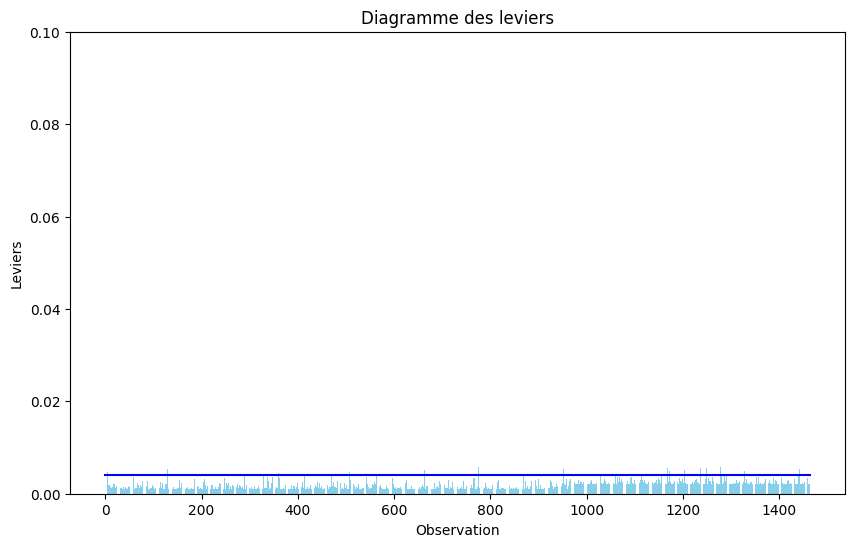

In [30]:
# Calcul des leviers
analyses['levier'] = regression_multiple.get_influence().hat_matrix_diag

# Etablissement du seuil pour les leviers
seuil_levier = 2 * p / n

# Affichage des leviers
plt.figure(figsize=(10, 6))
plt.bar(analyses['obs'], analyses['levier'], color='skyblue')

# Gestion du titre & des labels
plt.title('Diagramme des leviers')
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.ylim(0, 0.1)

# Aperçu
plt.plot([0, n], [seuil_levier, seuil_levier], color='b')
plt.show()

Aucun point de donnée ne semble avoir d'influence significative sur le modèle de régression. (< 0.02)

### Résidus studentisés

Les résidus studentisés mesurent à quel point chaque observation s'écarte de la tendance prévue, ajustée en fonction de l'ensemble des données.

Ils sont calculés en divisant la différence entre chaque observation et la valeur prédite par l'écart-type des résidus.

Ces résidus sont comparés à un seuil pour détecter les valeurs aberrantes ou influentes du modèle.



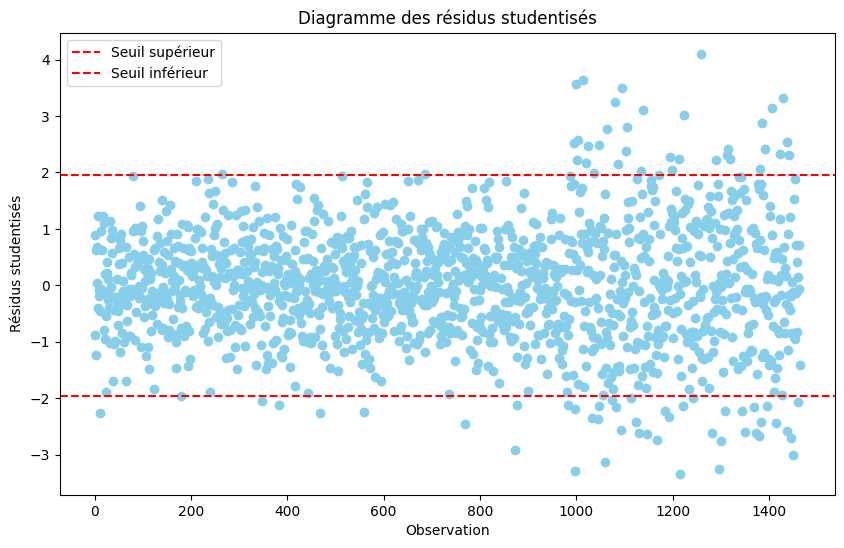

In [31]:
# Calcul des résidus studentisés
analyses['rstudent'] = regression_multiple.get_influence().resid_studentized_internal

# Seuil pour les résidus studentisés
seuil_rstudent = t.ppf(1 - alpha / 2, n - p - 1)

# Affichage des résidus studentisés
plt.figure(figsize=(10, 6))
plt.scatter(analyses['obs'], analyses['rstudent'], color='skyblue')
plt.axhline(y=seuil_rstudent, color='r', linestyle='--', label='Seuil supérieur')
plt.axhline(y=-seuil_rstudent, color='r', linestyle='--', label='Seuil inférieur')

# Gestion du titre, des labels et de la légende
plt.title('Diagramme des résidus studentisés')
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.legend()

# Aperçu du graphique
plt.show()

Il n'y a que très peu d'observations situées au-dessus du seuil supérieur ou en dessous du seuil inférieur, et ces dernières en reste relativement proches.

Cela suggère une absence d'observations aberrantes significatives dans le modèle.

### Distance de Cook

La distance de Cook mesure l'influence de chaque observation sur la régression statistique, et si elle dépasse un certain seuil, cela indique qu'une observation a un impact disproportionné sur les résultats du modèle.

Elle est calculée en évaluant à quel point les résultats de la régression changeraient si chaque observation était retirée une à une du modèle, puis en mesurant la distance entre les prédictions originales et les prédictions ajustées.

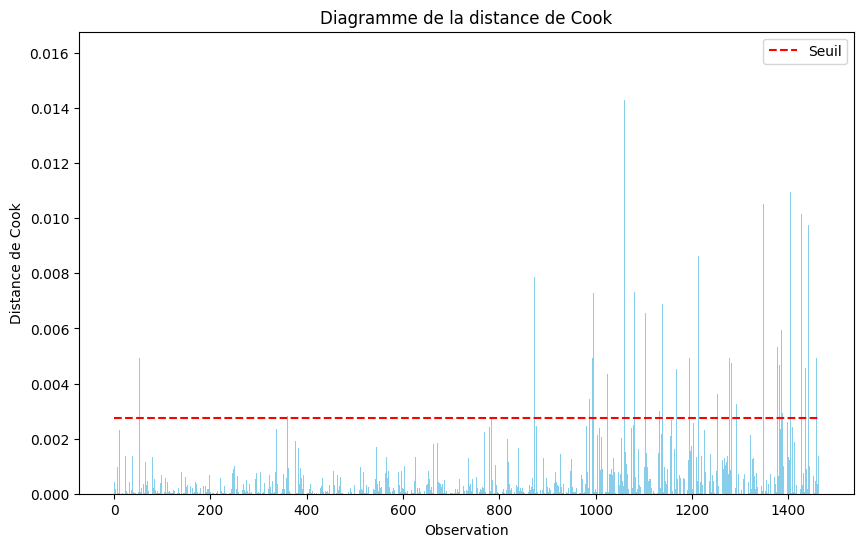

In [32]:
# Calcul de la distance de Cook
cook_distance = OLSInfluence(regression_multiple).cooks_distance[0]

# Seuil pour la distance de Cook
seuil_cook = 4 / (n - p)

# Affichage de la distance de Cook
plt.figure(figsize=(10, 6))
plt.bar(analyses['obs'], cook_distance, color='skyblue')
plt.plot([0, n], [seuil_cook, seuil_cook], color='r', linestyle='--', label='Seuil')

# Gestion du titre, des labels et de la légende
plt.title('Diagramme de la distance de Cook')
plt.xlabel('Observation')
plt.ylabel('Distance de Cook')
plt.legend()

# Aperçu du graphique
plt.show()

Aucun point de donnée ne semble avoir d'influence significative sur le modèle de régression. (< 0.02)

## Vérifications des hypothèses

Avant de valider l'utilisation de notre modèle de regression linéaire, nous devons vérifier plusieurs hypothèses :

- Multicolinéarité : Il ne devrait pas y avoir de forte corrélation linéaire entre les variables indépendantes.

- Homoscédasticité : La variance des erreurs résiduelles doit être constante à tous les niveaux de la variable prédite.

- Normalité : Les erreurs résiduelles doivent suivre une distribution normale.





### Multicolinéarité

 En présence de forte colinéarité, il devient compliqué de déterminer l'effet individuel de chaque variable indépendante sur la variable dépendante.

 Son indicateur est le VIF (Variation Inflation Factor), calculé en mesurant la variation de l'erreur standard d'un coefficient de régression lorsqu'une variable est ajoutée au modèle par rapport à lorsqu'elle est exclue.

In [33]:
# Calcul de la multicolinéarité des variables
variables = regression_multiple.model.exog

# Affichage des résultats
print("Variance Inflation Factor (VIF):")
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

Variance Inflation Factor (VIF):


[1.5938854494007753, 1.5938854494007748]

Les valeurs VIF pour les variables explicatives "is_genuine" et "margin_up" sont toutes deux de 1.59.

Cela indique une faible corrélation entre les variables.

En général, des valeurs de VIF inférieures à 2 suggèrent une absence de multicolinéarité significative.

### Homoscédasticité

L'hétéroscédasticité, c'est lorsque la dispersion des résidus d'une régression varie de manière non constante en fonction des valeurs des variables indépendantes.

Elle est calculée en testant statistiquement si la variance des résidus dépend significativement des variables explicatives de la régression.

In [34]:
# Test de Breusch Pagan
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regression_multiple.resid, variables)
print('P-value issus du test de Breusch Pagan:', pval)

P-value issus du test de Breusch Pagan: 3.2033559115836335e-36


Le résultat du test montre une p-value très faible (3.20e-36), ce qui indique une forte indication d'hétéroscédasticité, suggérant que la variance des résidus n'est pas constante.

In [35]:
# Test de White
_, pval, _, _ = statsmodels.stats.diagnostic.het_white(regression_multiple.resid, variables)
print('P-value issus du test de White:', pval)

P-value issus du test de White: 4.7699050163430157e-35


La p-value très faible obtenue à partir du test de White (4.77e-35) indique une forte indication d'homoscédasticité rejetant l'hypothèse nulle selon laquelle la variance des résidus est constante.

Cela suggère que la variance des résidus varie de manière significative en fonction des valeurs des variables indépendantes dans notre modèle de régression.

### Normalité

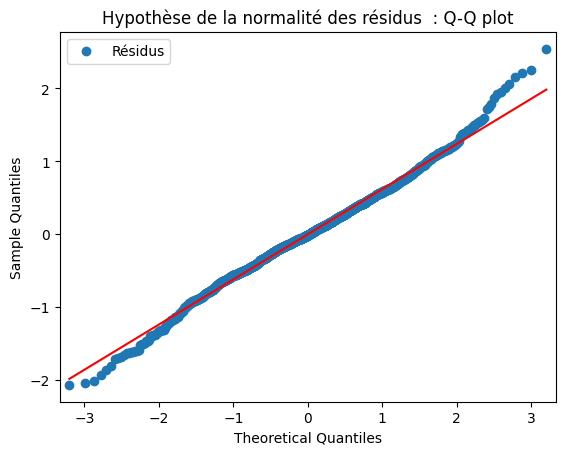

In [36]:
# Calcul des résidus
residuals = regression_multiple.resid

# Affichage graphique
sm.qqplot(residuals, line='s', label="Résidus")

# Gestion du titre et de la légende
plt.title("Hypothèse de la normalité des résidus  : Q-Q plot")
plt.legend()

# Aperçu du graphique
plt.show()

In [37]:
# Calcul des statistiques et de la P-value
statistic, p_value = shapiro(residuals)

if p_value > 0.05:
    print("Les résidus semblent suivre une distribution normale (hypothèse non rejetée).")
    print("P-value :",p_value)
else:
    print("Les résidus ne suivent pas une distribution normale (hypothèse rejetée).")
    print("P-value :",p_value)

Les résidus ne suivent pas une distribution normale (hypothèse rejetée).
P-value : 6.209468210727209e-06


 La p-value faible (6.21e-06) suggère que les résidus ne suivent pas une distribution normale.

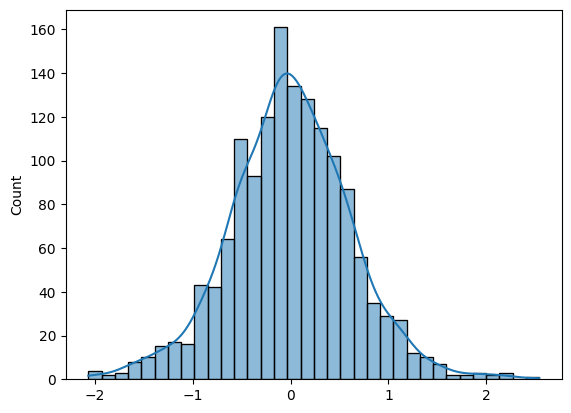

In [38]:
# Affichage graphique de la distribution des résidus
sns.histplot(residuals, kde=True)
plt.show()

## Conclusion

Hypothèse vérifiée :
- Multicolinéarité des variables indépendantes

Hypothèses non-vérifiées :
- Normalité des résidus
- Homoscédasticité des résidus

En résumé, bien que la multi-colinéarité des variables soit vérifiée, les violations des hypothèses de normalité et d'homoscédasticité des résidus peuvent remettre en question l'utilisation directe de la régression linéaire.

On pourrait pousser l'analyse en réalisant notamment une regression par moindre carrés pondérés ou encore une regression polynomiale.

Toutefois, dans l'attente des valeurs officielles, nous utiliserons comme demandé les valeurs prédites par notre régression linéaire.

# Contrôle de la conformité des billets

## Introduction

Utilisation de modèle d'apprentissage supervisés :
- Régression Logistique
- KNN
- Random Forest

Utilisation d'un modèle d'apprentissage non supervisé :
- Kmeans





## Datasets d'entrainements

In [64]:
# Séparation des données
X = scaled_data.drop('is_genuine', axis=1)
y = scaled_data['is_genuine']

In [65]:
# Datasets d'entrainements
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [66]:
# Affichez les valeurs uniques et leur nombre d'occurrences dans la Series
counts = y_test.value_counts()

# Afficher le nombre de billets conformes et non conformes
conformes = counts.get(1, 0)
non_conformes = counts.get(0, 0)

print("Le nombre de billets conforme dans le jeu test est de :", conformes)
print("Le nombre de billets non conforme le jeu test est de :", non_conformes)

Le nombre de billets conforme dans le jeu test est de : 504
Le nombre de billets non conforme le jeu test est de : 246


## Modèles d'apprentissage

### Régression logistique

In [42]:
# Identification des variables descriptives pertinentes
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
regression_logistique_backward = regression_logistic_backward(scaled_data[columns], 'is_genuine')

_______________________________
is_genuine ~ margin_up + length + margin_low + height_right + height_left + diagonal + 1
Optimization terminated successfully.
         Current function value: 0.026325
         Iterations 11
remove diagonal (p-value: 0.814 )

_______________________________
is_genuine ~ margin_up + length + margin_low + height_right + height_left + 1
Optimization terminated successfully.
         Current function value: 0.026344
         Iterations 11
remove height_left (p-value: 0.254 )

_______________________________
is_genuine ~ margin_up + length + margin_low + height_right + 1
Optimization terminated successfully.
         Current function value: 0.026784
         Iterations 11
is the final model!

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1495
Method:                          

Pour notre modèle, les variables descriptives significatives sont donc les suivantes :

- "margin_low"
- "margin_up"
- "length"
- "height_right"

Le Pseudo R-Square à 0,95 signifie que le modèle explique une grande partie des variations au sein de la variable de réponse "is_genuine".

In [43]:
# Séparation des données
X_log = scaled_data[['length', 'margin_low', 'margin_up', 'height_right']]
y_log = scaled_data['is_genuine']

# Datasets d'entrainements
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.5, random_state=42)

# Initialisation du modèle
modele_reg_log = LogisticRegression()

# Entrainement sur les données
modele_reg_log.fit(X_train_log, y_train_log)

# Prédiction du modèle
y_pred_reg_log = modele_reg_log.predict(X_test_log)

In [44]:
# Affichez les valeurs uniques et leur nombre d'occurrences dans la Series
counts = y_test_log.value_counts()

# Afficher le nombre de billets conformes et non conformes
conformes = counts.get(1, 0)
non_conformes = counts.get(0, 0)

print("Le nombre de billets conforme dans le jeu test est de :", conformes)
print("Le nombre de billets non conforme le jeu test est de :", non_conformes)

Le nombre de billets conforme dans le jeu test est de : 504
Le nombre de billets non conforme le jeu test est de : 246


In [45]:
# Mesures des performances du modèle
precision_log = precision_score(y_test_log, y_pred_reg_log)
recall_log = recall_score(y_test_log, y_pred_reg_log)
f1_log = f1_score(y_test_log, y_pred_reg_log)
accuracy_log = accuracy_score(y_test_log, y_pred_reg_log)

# Affichage sous forme de tableau
results_log = pd.DataFrame({
    'Metric': ['Précision', 'Rappel', 'F1 score', 'Accuracy'],
    'Score (%)': [precision_log * 100, recall_log * 100, f1_log * 100, accuracy_log * 100]
})

# Arrondi des valeurs à deux chiffres après la virgule
results_log['Score (%)'] = results_log['Score (%)'].round(2)

# Affichage des résultats
results_log

,Metric,Score (%)
0,Précision,99.21
1,Rappel,99.60
2,F1 score,99.41
3,Accuracy,99.20


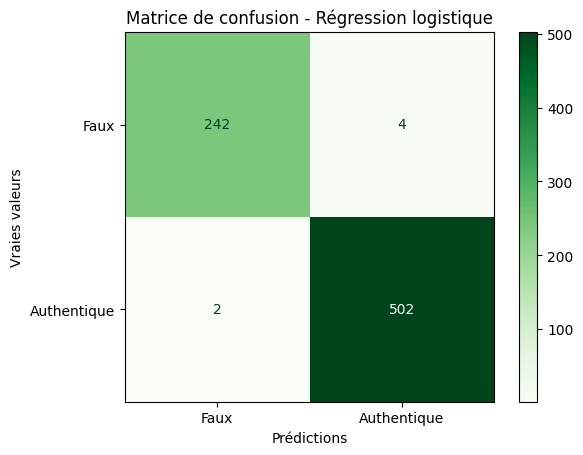

In [46]:
# Calcul de la matrice de confusion
matrix_confusion_logistique = confusion_matrix(y_test_log, y_pred_reg_log)

# Affichage de la matrice de confusion
classes = ["Faux", "Authentique"]
matrix_confusion_logistique_display = ConfusionMatrixDisplay(confusion_matrix=matrix_confusion_logistique,
                                                            display_labels=classes)

# Gestion de la couleur
matrix_confusion_logistique_display.plot(cmap='Greens')

# Gestion du titre
plt.title('Matrice de confusion - Régression logistique')

# Gestion des labels
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')

# Enregistrer le graphique
plt.savefig("matx_RL.png")

# Affichage du graphique
plt.show()

✅ TP - True Positives ( Vrais Positifs ) : Le modèle prédit qu'un billet est authentique, et en réalité, le billet est effectivement authentique.

✅ TN - True Negatives ( Vrais Négatifs ) : Le modèle prédit qu'un billet est faux, et en réalité, le billet est effectivement faux.

❌ FP - False Positives ( Faux Positifs ) : Le modèle prédit qu'un billet est authentique, mais en réalité, le billet est faux.

❌ FN - False Negatives ( Faux Négatifs ) : Le modèle prédit qu'un billet est faux, mais en réalité, le billet est authentique.

Sur 750 billets :
- ✅ 746 billets ont été classés correctement
- ❌ 4 billets ont été mal classés

Sur 246 faux billets :
- ✅ 242 ont été classés comme faux ( TN )
- ❌ 4 ont été classés comme vrais ( FP )

Sur 504 billets authentiques :
- ✅ 502 ont été classés comme vrais ( TP )
- ❌ 2 ont été classés comme faux ( FN )

PRECISION / Lorsque le modèle identifie un billet comme étant faux, il a raison : minimise le risque de fausses alertes, ce qui est essentiel pour éviter de rejeter à tort des billets authentiques.

- TP / TP + FP
- 502 / 502 + 4 = 0,9920

RECALL / Le modèle est capable de capturer les faux billets présents dans l'ensemble de test : Crucial pour assurer la fiabilité de la détection des faux billets.

- TP / TP + FN
- 502 / 502 + 2 = 0,9960

F1 SCORE / Représente la moyenne harmonique de la précision et du rappel : Fournit une mesure globale de l'exactitude du modèle, en tenant compte à la fois des faux positifs et des faux négatifs.

- 2 * ((precision * rappel) / (precision / rappel))   
- 2 * (( 0,9920 * 0,9960 ) / ( 0,9920 + 0,9960 )) = 0.9939

ACCURACY / Mesure simple de la performance globale du modèle : Utile pour donner une vue d'ensemble de la performance du modèle en termes de pourcentage de prédictions correctes parmi toutes les prédictions effectuées.

- TP + TN / TP + TN + FP + FN
- 502 + 242 / 502 + 242 + 4 + 2 = 0,992

In [47]:
# Enregistrement du modèle
joblib.dump(modele_reg_log, 'Modele_Regression_Logistique.joblib')

['Modele_Regression_Logistique.joblib']

### Clustering Kmeans

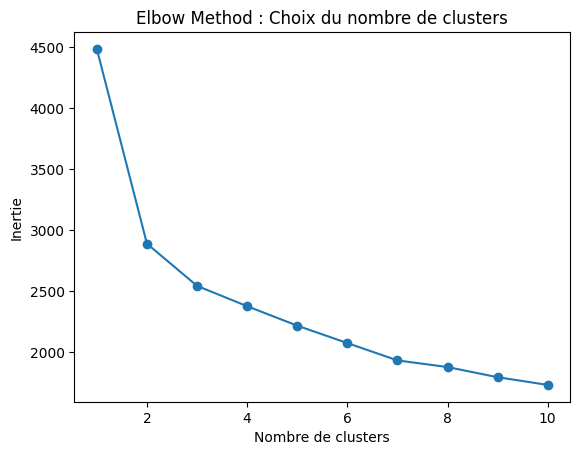

In [48]:
# Initialisation d'une liste vide pour stocker les valeurs de l'inertie
inertia = []

# Tester différentes valeurs de k pour KMeans
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

# Graphique de l'inertie en fonction du nombre de clusters
plt.plot(range(1, 11), inertia, marker='o')

# Gestion du titre et des labels
plt.title('Elbow Method : Choix du nombre de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')

# Affichage du graphique
plt.show()

In [49]:
# Création de l'objet KMeans avec 2 clusters (vrais ou faux)
modele_kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')

# Ajustement du modèle
modele_kmeans.fit(X_train)

# Prédiction des clusters
y_pred_kmeans = modele_kmeans.predict(X_test)

In [50]:
# Mesures des performances du modèle
precision_kmeans = precision_score(y_test, y_pred_kmeans)
recall_kmeans = recall_score(y_test, y_pred_kmeans)
f1_kmeans = f1_score(y_test, y_pred_kmeans)
accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)

# Affichage sous forme de tableau
results_kmeans = pd.DataFrame({
    'Metric': ['Précision', 'Rappel', 'F1 score', 'Accuracy'],
    'Score (%)': [precision_kmeans * 100, recall_kmeans * 100, f1_kmeans * 100, accuracy_kmeans * 100]
})

# Arrondi des valeurs à deux chiffres après la virgule
results_kmeans['Score (%)'] = results_kmeans['Score (%)'].round(2)

# Affichage des résultats
results_kmeans

,Metric,Score (%)
0,Précision,99.00
1,Rappel,98.21
2,F1 score,98.61
3,Accuracy,98.13


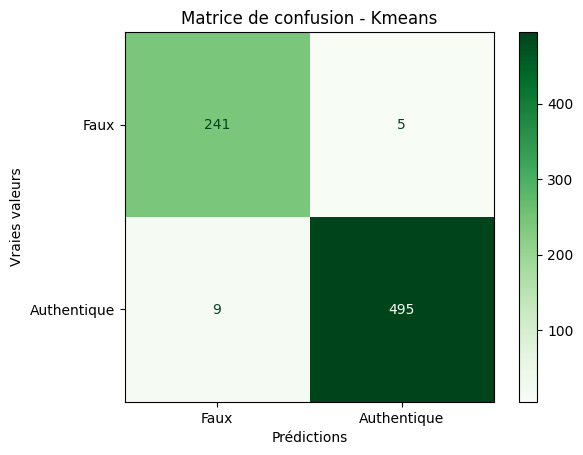

In [51]:
# Calcul de la matrice de confusion
matrix_confusion_kmeans = confusion_matrix(y_test, y_pred_kmeans)

# Affichage de la matrice de confusion
classes = ["Faux", "Authentique"]
matrix_confusion_kmeans_display = ConfusionMatrixDisplay(confusion_matrix=matrix_confusion_kmeans,
                                                            display_labels=classes)

# Gestion de la couleur
matrix_confusion_kmeans_display.plot(cmap='Greens')

# Gestion du titre
plt.title('Matrice de confusion - Kmeans')

# Gestion des labels
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')

# Enregistrer le graphique
plt.savefig("matx_KM.png")

# Affichage du graphique
plt.show()

Sur 750 billets :
- ✅ 736 billets ont été classés correctement
- ❌ 14 billets ont été mal classés

Sur 246 faux billets :
- ✅ 241 ont été classés comme faux ( TN )
- ❌ 5 ont été classés comme vrais ( FP )

Sur 504 billets authentiques :
- ✅ 495 ont été classés comme vrais ( TP )
- ❌ 9 ont été classés comme faux ( FN )

PRECISION /
- TP / TP + FP
- 495 / 495 + 5 = 0,99

RECALL /
- TP / TP + FN
- 495 / 495 + 9 = 0,9821

F1 SCORE /
- 2 * ((precision * rappel) / (precision / rappel))   
- 2 * (( 0,99 * 0,9821 ) / ( 0,99 + 0,9821 )) = 0.9851

ACCURACY /
- TP + TN / TP + TN + FP + FN
- 495 + 241 / 495 + 241 + 5 + 9 = 0,9813



In [52]:
# Enregistrement du modele
joblib.dump(modele_kmeans, 'Modele_Kmeans.joblib')

['Modele_Kmeans.joblib']

### K-Nearest Neighbors



Valeur optimale pour k (Paramètre:Accuracy): 10


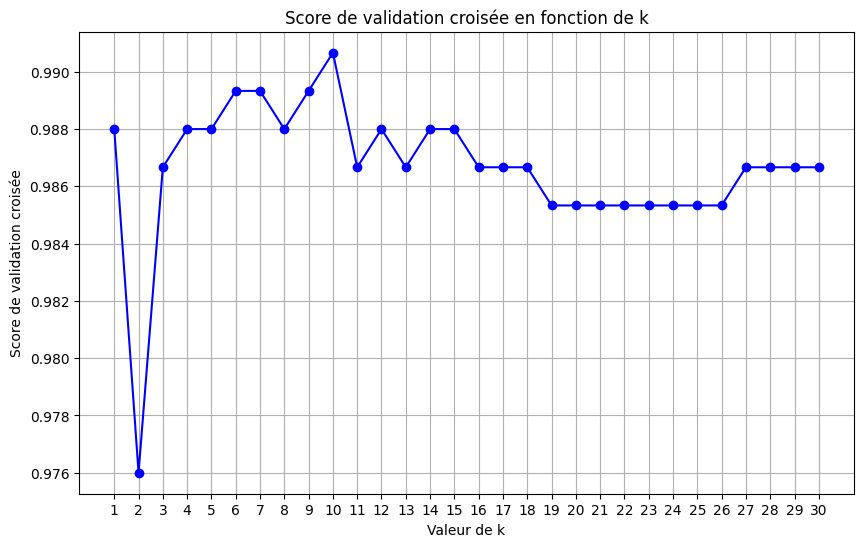

In [53]:
# Liste pour stocker les scores de validation croisée
cv_scores = []

# Liste des valeurs de k à tester
k_values = list(range(1, 31))

# Effectuer la validation croisée pour chaque valeur de k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy') # Paramètrage
    cv_scores.append(scores.mean())

# Trouver la meilleure valeur de k
best_k = k_values[cv_scores.index(max(cv_scores))]
print("Valeur optimale pour k (Paramètre:Accuracy):", best_k)

# Afficher les résultats de la validation croisée
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')

# Gestion du titre et des labels
plt.title('Score de validation croisée en fonction de k')
plt.xlabel('Valeur de k')
plt.ylabel('Score de validation croisée')

# Gestion de l'affichage général
plt.xticks(k_values)
plt.grid(True)

# Affichage du graphique
plt.show()

In [54]:
# Initialiser le classifieur KNN
modele_knn = KNeighborsClassifier(n_neighbors=10)

# Entrainement du modèle
modele_knn.fit(X_train, y_train)

# Prédiction du modèle
y_pred_knn = modele_knn.predict(X_test)

In [55]:
# Mesures des performances du modèle
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Affichage sous forme de tableau
results_knn = pd.DataFrame({
    'Metric': ['Précision', 'Rappel', 'F1 score', 'Accuracy'],
    'Score (%)': [precision_knn * 100, recall_knn * 100, f1_knn * 100, accuracy_knn * 100]
})

# Arrondi des valeurs à deux chiffres après la virgule
results_knn['Score (%)'] = results_knn['Score (%)'].round(2)

# Affichage des résultats
results_knn

,Metric,Score (%)
0,Précision,99.60
1,Rappel,99.40
2,F1 score,99.50
3,Accuracy,99.33


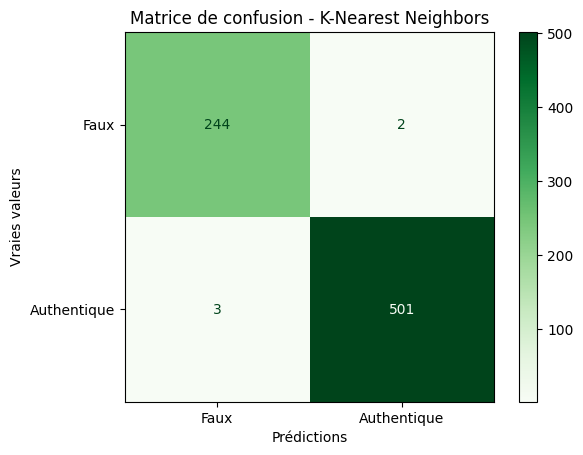

In [56]:
# Calcul de la matrice de confusion
matrix_confusion_knn = confusion_matrix(y_test, y_pred_knn)

# Affichage de la matrice de confusion
classes = ["Faux", "Authentique"]
matrix_confusion_knn_display = ConfusionMatrixDisplay(confusion_matrix=matrix_confusion_knn,
                                                            display_labels=classes)

# Gestion de la couleur
matrix_confusion_knn_display.plot(cmap='Greens')

# Gestion du titre
plt.title('Matrice de confusion - K-Nearest Neighbors')

# Gestion des labels
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')

# Enregistrer le graphique
plt.savefig("matx_KN.png")

# Affichage du graphique
plt.show()

Sur 750 billets :
- ✅ 745 billets ont été classés correctement
- ❌ 5 billets ont été mal classés

Sur 246 faux billets :
- ✅ 244 ont été classés comme faux ( TN )
- ❌ 2 ont été classés comme vrais ( FP )

Sur 504 billets authentiques :
- ✅ 501 ont été classés comme vrais ( TP )
- ❌ 3 ont été classés comme faux ( FN )

PRECISION /
- TP / TP + FP
- 501 / 501 + 2 = 0,9960

RECALL /
- TP / TP + FN
- 501 / 501 + 3 = 0,9940

F1 SCORE /
- 2 * ((precision * rappel) / (precision / rappel))   
- 2 * (( 0,9960 * 0,9940 ) / ( 0,9960 + 0,9940 )) = 0,9950

ACCURACY /
- TP + TN / TP + TN + FP + FN
- 501 + 244 / 501 + 244 + 2 + 3 = 0,9933

In [57]:
# Enregistrement du modele
joblib.dump(modele_knn, 'Modele_KNN.joblib')

['Modele_KNN.joblib']

### Random Forest

Nombre optimal pour n_estimators (Paramètre:Accuracy): 250


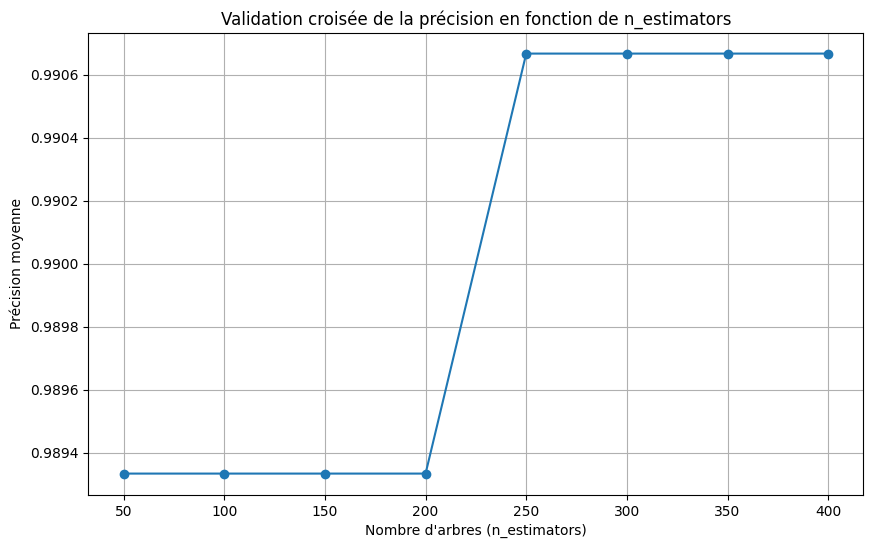

In [58]:
# Liste pour stocker les scores de validation croisée moyens
cross_val_scores = []

# Liste des valeurs de n_estimators à tester
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400]

# Calculer les scores de validation croisée pour chaque valeur de n_estimators
for n in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy') # Parametrage
    cross_val_scores.append(scores.mean())

# Trouver le nombre optimal d'arbres
optimal_n_estimators = n_estimators_values[np.argmax(cross_val_scores)]
print("Nombre optimal pour n_estimators (Paramètre:Accuracy):", optimal_n_estimators)

# Courbe de validation croisée
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, cross_val_scores, marker='o', linestyle='-')

# Gestion du titre, des labels et de la grille
plt.title('Validation croisée de la précision en fonction de n_estimators')
plt.xlabel('Nombre d\'arbres (n_estimators)')
plt.ylabel('Précision moyenne')
plt.grid(True)

# Affichage du graphique
plt.show()

In [59]:
# # Initialiser le Classifier
modele_rf = RandomForestClassifier(n_estimators=250, random_state=42)

# Entrainement du modèle
modele_rf.fit(X_train, y_train)

# Prédiction du modèle
y_pred_rf = modele_rf.predict(X_test)

In [60]:
# Mesures des performances du modèle
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Affichage sous forme de tableau
results_rf = pd.DataFrame({
    'Metric': ['Précision', 'Rappel', 'F1 score', 'Accuracy'],
    'Score (%)': [precision_rf * 100, recall_rf * 100, f1_rf * 100, accuracy_rf * 100]
})

# Arrondi des valeurs à deux chiffres après la virgule
results_rf['Score (%)'] = results_rf['Score (%)'].round(2)

# Affichage des résultats
results_rf

,Metric,Score (%)
0,Précision,99.4
1,Rappel,99.4
2,F1 score,99.4
3,Accuracy,99.2


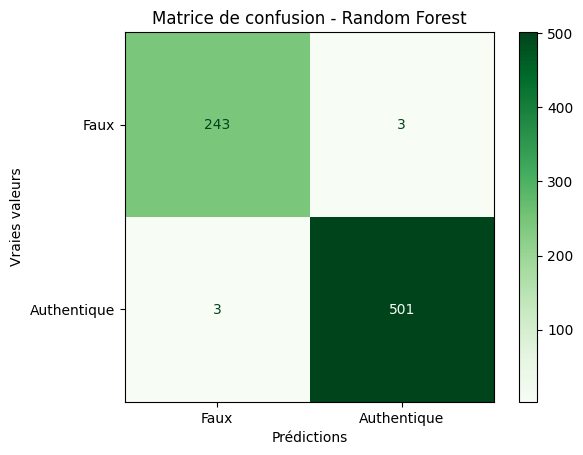

In [61]:
# Calcul de la matrice de confusion
matrix_confusion_rf = confusion_matrix(y_test, y_pred_rf)

# Affichage de la matrice de confusion
classes = ["Faux", "Authentique"]
matrix_confusion_rf_display = ConfusionMatrixDisplay(confusion_matrix=matrix_confusion_rf,
                                                            display_labels=classes)

# Gestion de la couleur
matrix_confusion_rf_display.plot(cmap='Greens')

# Gestion du titre
plt.title('Matrice de confusion - Random Forest')

# Gestion des labels
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')

# Enregistrer le graphique
plt.savefig("matx_RF.png")

# Affichage du graphique
plt.show()

Sur 750 billets :
- ✅ 744 billets ont été classés correctement
- ❌ 6 billets ont été mal classés

Sur 246 faux billets :
- ✅ 243 ont été classés comme faux ( TN )
- ❌ 3 ont été classés comme vrais ( FP )

Sur 504 billets authentiques :
- ✅ 501 ont été classés comme vrais ( TP )
- ❌ 3 ont été classés comme faux ( FN )

PRECISION /
- TP / TP + FP
- 501 / 501 + 3 = 0,9940

RECALL /
- TP / TP + FN
- 501 / 501 + 3 = 0,9940

F1 SCORE /
- 2 * ((precision * rappel) / (precision / rappel))   
- 2 * (( 0,9940 * 0,9940 ) / ( 0,9940 + 0,9940 )) = 0,9950

ACCURACY /
- TP + TN / TP + TN + FP + FN
- 501 + 243 / 501 + 243 + 3 + 3 = 0,992

In [62]:
# Enregistrement du modèle
joblib.dump(modele_rf, 'Modele_Random_Forest.joblib')

['Modele_Random_Forest.joblib']

# Conclusion

In [63]:
# Création d'un dictionnaire contenant les résultats
results_final = {
    'Modèle': ['Régression Logistique', 'Kmeans', 'KNN', 'Random Forest'],
    'Précision': [precision_log, precision_kmeans, precision_knn, precision_rf],
    'Rappel': [recall_log, recall_kmeans, recall_knn, recall_rf],
    'F1 Score': [f1_log, f1_kmeans, f1_knn, f1_rf],
    'Précision Globale': [accuracy_log, accuracy_kmeans, accuracy_knn, accuracy_rf]
}

# Création d'un DataFrame à partir du dictionnaire
df = pd.DataFrame(results_final)

# Convertir les scores en pourcentage avec deux chiffres après la virgule
df['Précision'] = (df['Précision'] * 100).round(2)
df['Rappel'] = (df['Rappel'] * 100).round(2)
df['F1 Score'] = (df['F1 Score'] * 100).round(2)
df['Précision Globale'] = (df['Précision Globale'] * 100).round(2)

# Trier les valeurs en fonction du Recall
df_sorted = df.sort_values(by='Rappel', ascending=False)
df_sorted = df_sorted.reset_index(drop=True)

# Afficher le resultat
df_sorted

,Modèle,Précision,Rappel,F1 Score,Précision Globale
0,Régression Logistique,99.21,99.60,99.41,99.20
1,KNN,99.60,99.40,99.50,99.33
2,Random Forest,99.40,99.40,99.40,99.20
3,Kmeans,99.00,98.21,98.61,98.13
